# <center>Wskaźnik giełdowy MACD</center>
## <center>Wiktoria Lewicka 184915</center>

Celem projektu jest ocena przydatności MACD w analizie technicznej na podstawie działania algorytmu symulującego kupno i sprzedaż akcji według wskaźnika MACD

Import wszystkich niezbędnych modułow:
pandas - do pobrania i przetwarzania danych z pliku .csv
matplotlib - do rysowania wykresów

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

Pobranie danych z pliku .csv

In [87]:
# BTC > PLN
# dane ze strony https://stooq.pl/q/d/?s=btcpln
df = pd.read_csv('C:\\Users\\vip\\Documents\\MACDprojekt\\ALXN.csv', nrows=1000)

Funkcja pomocnicza do obliczania EMA (wykładniczej średniej kroczącej), wykonująca operacje na seriach danych po N elementów.
Wykładnicza średnia krocząca dla jednego okresu (1 serii danych) obliczana jest według następującego
wzoru:
$$\mathrm{EMA}_{n}=\frac{\mathrm{p}_{0}+(1-\alpha)\mathrm{p}_{1}+(1-\alpha)^2\mathrm{p}_{2}+...+(1-\alpha)^N\mathrm{p}_{N}}{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^N}$$


In [88]:
def ema_comp(data):
    n = data.size
    alfa = 2.0 / (n + 1.0)
    meter = 0.0
    denominator = 0.0

    for index, value in data.items():
        meter += pow((1.0 - alfa), index) * value
        denominator += pow((1.0 - alfa), index)

    return meter / denominator

Funkcja obliczająca EMA, jako argumenty przyjmuje:
- n: okres czasu w dniach z jakiego ma być kolejno liczona średnia krocząca
- data: seria danych, na których mają być wykonywane obliczenia

In [93]:
def ema(n, data):
    em = data.rolling(window=n, min_periods=n).apply(ema_comp)
    return em;

Obliczenie EMA 26 i 12 okresową:

In [94]:
ema12 = ema(12, df["Close"])
ema26 = ema(26, df["Close"])

Obliczenie MACD i Signal:

In [95]:
df["MACD"] = ema12 - ema26
df["Signal"] = ema(9, df["MACD"])

Wypisanie obliczonych danych

In [96]:
print(df[["Date", "Close", "MACD", "Signal"]])

           Date       Close      MACD    Signal
0    2014-03-14  175.279999       NaN       NaN
1    2014-03-17  177.990005       NaN       NaN
2    2014-03-18  180.940002       NaN       NaN
3    2014-03-19  175.919998       NaN       NaN
4    2014-03-20  173.660004       NaN       NaN
..          ...         ...       ...       ...
995  2018-02-26  121.330002 -5.570597 -4.929623
996  2018-02-27  118.339996 -4.019081 -5.514296
997  2018-02-28  117.449997 -1.990825 -5.654376
998  2018-03-01  115.110001 -0.920957 -5.510528
999  2018-03-02  117.919998  0.584609 -5.109239

[1000 rows x 4 columns]


Narysowanie wykresów Signal i MACD:

<AxesSubplot:>

<Figure size 3200x2400 with 0 Axes>

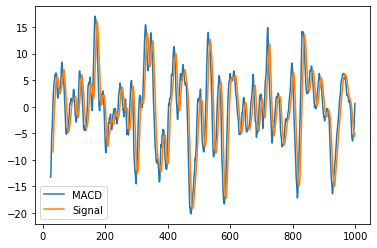

In [135]:
plt.figure(figsize=(8, 6), dpi=100)
df[['MACD','Signal']].plot()

<AxesSubplot:>

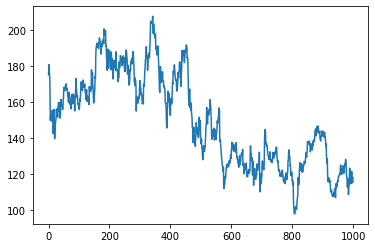

In [98]:
plt.figure()
df['Close'].plot()

**Wnioski na podstawie otrzymanych wykresów:** linie MACD i Signal przecinają się w okolicach maksymalnego wzrostu lub spadku wartości akcji. Oznacza to, że można wykorzystać wskaźnik MACD w celu zwiększenia przychodu z kupna i sprzedaży akcji.

## Algorytm kupujący i sprzedający akcje
Poniższy algorytm kupuje n akcji, gdy MACD przecina SIGNAL od dołu i sprzedaje 2*n akcji, gdy MACD przecina SIGNAL od góry.
Celem algorytmu jest powiększenie wirtualnego majątku.

Poprzez porównianie bieżących i poprzednich wartości Signal i MACD algorytm ten decyduje, czy opłaca się sprzedać albo kupić akcje:
- jeśli nastąpi dobry moment na kupno, kupowane jest n akcji
- jeśli jest dobry moment na sprzedaż, sprzedawane jest n*20 akcji

Pieniądze w budżecie nie tracą na wartości, dlatego algorytm wydaje mniej pieniędzy i sprzedaje więcej akcji. W ten sposób przychód nie będzie zbyt szybko rosnąć, jednak również w przypadku pomyłki algorytmu, straty nie powinny zrujnować budżetu.

In [140]:
def sell_buy(budget, actions, n, df):
    prev_mac = df.iloc[0]["MACD"]
    prev_signal = df.iloc[0]["Signal"]
    
    sell_counter = 0;
    buy_counter = 0;

    print("Stan początkowy")
    print("Saldo: ", budget, " wartosc akcji: ", round(actions * df.loc[0]["Close"]),
          " Razem: ", round(budget + actions * df.loc[0]["Close"]))

    df = df.reset_index()
    for index, row in df.iterrows():
        if row["Signal"] > row["MACD"] and prev_signal < prev_mac:
            if n * row["Close"] <= budget:
                budget -= n * row["Close"]
                actions += n
                buy_counter += n

        if row["Signal"] < row["MACD"] and prev_signal > prev_mac:
            if actions >= n * 2:
                actions -= n * 2
                budget += n * 2 * row["Close"]
                sell_counter += n * 2

        prev_mac = row['MACD']
        prev_signal = row['Signal']

    print("Stan koncowy")
    print("Saldo: ", round(budget), " wartosc akcji: ", round(actions * df.loc[0]["Close"]),
          " Razem: ", round(budget + actions * df.iloc[-1]["Close"]))
    print("Liczba sprzedanych akcji: ", sell_counter)
    print("Liczba kupionych akcji: ", buy_counter)

**Test algorytmu dla wartości:**
- budżet początkowy: 1000
- początowa liczba akcji: 0
- liczba kupowanych akcji podczas spadku: 5
- liczba sprzedawanych akcji podczas wzrostu: 5*2 = 10

In [141]:
sell_buy(1000, 0, 5, df)

Stan początkowy
Saldo:  1000  wartosc akcji:  0  Razem:  1000
Stan koncowy
Saldo:  208  wartosc akcji:  876  Razem:  798
Liczba sprzedanych akcji:  0
Liczba kupionych akcji:  5


W tym przypadku algorytm zarobił.

**Test algorytmu dla wartości:**
- budżet początkowy: 100000
- początowa liczba akcji: 500
- liczba kupowanych akcji podczas spadku: 50
- liczba sprzedawanych akcji podczas wzrostu: 50*2 = 100

In [142]:
sell_buy(100000, 500, 50, df)

Stan początkowy
Saldo:  100000  wartosc akcji:  87640  Razem:  187640
Stan koncowy
Saldo:  190430  wartosc akcji:  0  Razem:  190430
Liczba sprzedanych akcji:  2200
Liczba kupionych akcji:  1700


W tym przypadku algorytmowi udało się zarobić

**Test algorytmu dla wartości:**
- budżet początkowy: 0
- początowa liczba akcji: 500
- liczba kupowanych akcji podczas spadku: 50
- liczba sprzedawanych akcji podczas wzrostu: 50*2 = 100

In [143]:
sell_buy(0, 500, 50, df)

Stan początkowy
Saldo:  0  wartosc akcji:  87640  Razem:  87640
Stan koncowy
Saldo:  82407  wartosc akcji:  8764  Razem:  88303
Liczba sprzedanych akcji:  2100
Liczba kupionych akcji:  1650


Tym razem również algorytmowi udało się zarobić.

**Test algorytmu dla wartości:**
- budżet początkowy: 10000
- początowa liczba akcji: 0
- liczba kupowanych akcji podczas spadku: 50
- liczba sprzedawanych akcji podczas wzrostu: 50*2 = 100

In [144]:
sell_buy(100000, 0, 50, df)

Stan początkowy
Saldo:  100000  wartosc akcji:  0  Razem:  100000
Stan koncowy
Saldo:  100721  wartosc akcji:  0  Razem:  100721
Liczba sprzedanych akcji:  1700
Liczba kupionych akcji:  1700


W tym przypadku algorytm zarobił.

## Wnioski
Algorytmowi udało się zarobić, więc wyznaczanie odpowiednich momentów na kupno i sprzedaż akcji za pomocą wskaźnika MACD działa. Wskaźnik MACD na pewno jest jednym z wyznaczników, które warto przeanalizować w przypadku inwestycji w akcje.